In [1]:
import pandas as pd
import numpy as np
from os import walk, getcwd

In [2]:
f = []
for (dirpath, dirnames, filenames) in walk(getcwd()):
    f.extend(filenames)
    break

In [3]:
import pyreadstat

In [4]:
def read_spss(module, f = f):
    files = [i for i in f if module in i]
    if len(files) == 1:
        return pyreadstat.read_sav(files[0], apply_value_formats=True, 
                                formats_as_category=True, formats_as_ordered_category=False)
    else: raise Exception('More than one file!')
    

In [15]:
ac, ac_meta = read_spss('ac')
mh, mh_meta = read_spss('mh')
ph, ph_meta = read_spss('ph')
dn, dn_meta = read_spss('dn')
ep, ep_meta = read_spss('ep')
co, co_meta = read_spss('co')
gv_imputations, gv_imputations_meta = read_spss('gv_imputations')

In [16]:
def get_desc_df(df, meta):
    desc = pd.DataFrame({
        "var":meta.column_names,
        "varlab":meta.column_labels,
        "values":list(meta.readstat_variable_types.values()),
        "uniques":[len(set(df[i])) for i in df],
        'nas': list(df.isna().sum()),

    })
    return desc

In [17]:
ac_desc = get_desc_df(ac, ac_meta)
gov_dsec = get_desc_df(gv_imputations, gv_imputations_meta)

In [18]:
cols_to_use = [i for i in ac if (('ac036_' not in i) and ('ac037_' not in i) and ('ac038_' not in i) and ('ac040' not in i)
                                and ('hhid7' not in i) and ('mergeidp7' not in i) and ('coupleid7' not in i) and ('language' not in i))]

In [19]:
ac = ac[cols_to_use]

In [20]:
ac[ac['country'] == 'Romania'].isna().sum()

mergeid        0
country        0
ac012_         5
ac014_         5
ac015_         5
ac016_         5
ac017_         5
ac018_         5
ac019_         5
ac020_         5
ac021_      2114
ac022_         5
ac023_         5
ac024_         5
ac025_         5
ac035d1       43
ac035d4       43
ac035d5       43
ac035d7       43
ac035d8       43
ac035d9       43
ac035d10      43
ac035dno      43
ac701_         5
ac702_         5
ac703_         5
ac704_         5
ac705_         5
ac706_         5
ac707_         5
ac708_         5
ac709_         5
ac710_         5
ac711_         5
ac740_         5
dtype: int64

In [21]:
ac['ac021_'].cat.add_categories(['Interpolated'], inplace = True)

In [22]:
ac = ac.apply(
    lambda x: x.apply(
        lambda y: np.nan if (y == "Don't know") or (y == "Refusal") else y
                        
    )
)

In [25]:
ac.loc[ac['country'] == 'Romania', ['ac021_']] = 'Interpolated'

In [26]:
ac[ac['country'] == 'Romania'].isna().sum()

mergeid      0
country      0
ac012_      14
ac014_       7
ac015_       8
ac016_       8
ac017_       7
ac018_       8
ac019_       7
ac020_       7
ac021_       0
ac022_       7
ac023_       7
ac024_       7
ac025_       8
ac035d1     44
ac035d4     44
ac035d5     44
ac035d7     44
ac035d8     44
ac035d9     44
ac035d10    44
ac035dno    44
ac701_       7
ac702_       7
ac703_       7
ac704_       7
ac705_       7
ac706_       7
ac707_       7
ac708_       8
ac709_       7
ac710_       8
ac711_       7
ac740_       5
dtype: int64

In [27]:
ac = ac.dropna().reset_index(drop=True)

In [28]:
for i in ac:
  
    ac[i] = ac[i].apply(lambda x: 1 if x == 'Not selected' else x)\
    .apply(lambda x: 5 if x == 'Selected' else x)


    ac[i] = ac[i].apply(lambda x: 1 if x == 'Never' else x)\
    .apply(lambda x: 2 if x == 'Rarely' else x)\
    .apply(lambda x: 3 if x == 'Sometimes' else x)\
    .apply(lambda x: 4 if x == 'Often' else x)


    ac[i] = ac[i].apply(lambda x: 1 if x == 'Disagree strongly' else x)\
    .apply(lambda x: 2 if x == 'Disagree a little' else x)\
    .apply(lambda x: 3 if x == 'Neither agree nor disagree' else x)\
    .apply(lambda x: 4 if x == 'Agree a little' else x)\
    .apply(lambda x: 5 if x == 'Agree strongly' else x)
    

In [29]:
gv_aim = gv_imputations[['mergeid', 'age', 'gender', 'single', 'mstat', 'yedu', 'cjs', 'thinc2']].dropna()

In [30]:
gv_aim.shape

(386010, 8)

In [31]:
gv_aim = gv_aim.groupby('mergeid').first()

In [32]:
gv_aim = gv_aim[gv_aim['age'] >= 50]

In [33]:
df = ac.merge(gv_aim, on='mergeid')

In [34]:
df_wage_life_satisfaction = df.groupby('country').agg({"thinc2":"median", "ac012_":"mean"})
df_wage_life_satisfaction.columns = ['Median Wage', 'Life Satisfaction']

In [35]:
df_wage_life_satisfaction

,Median Wage,Life Satisfaction
country,,
Austria,27600.000000,8.253930
Belgium,29557.368651,7.738783
Bulgaria,3681.357906,6.210499
Croatia,8038.908513,7.117545
Cyprus,18000.000000,7.897864
Czech Republic,10028.109012,7.599840
Denmark,43556.582857,8.536147
Estonia,9480.000000,6.888740
Finland,33600.000000,8.329060


In [36]:
import plotly.express as px

In [57]:
fig = px.choropleth(df_wage_life_satisfaction.reset_index(), locations="country", 
                    locationmode='country names', color="Median Wage", 
                    hover_name="country", scope ='europe', color_continuous_scale="blues", 
                    title='Median Wage')
fig.update(layout_coloraxis_showscale=True)
fig.show()

In [47]:
fig = px.choropleth(df_wage_life_satisfaction.reset_index(), locations="country", 
                    locationmode='country names', color="Life Satisfaction", 
                    hover_name="country", scope ='europe',color_continuous_scale="greens", 
                    title='Life Satisfaction')
fig.update(layout_coloraxis_showscale=True)
fig.show()

In [65]:
es = df.groupby('cjs').agg({"ac012_":"mean", "ac016_":"mean", "ac017_":"mean"})
es.columns = ['LifeSat', 'LeftOut', 'DoWhatWant']

<AxesSubplot:ylabel='cjs'>

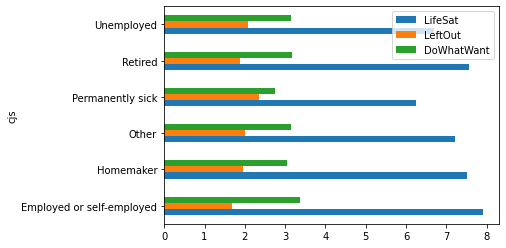

In [69]:
es.dropna().plot.barh()